In [203]:
import logging
from typing import Optional

import cv2
import numpy as np
import os
from imutils.perspective import four_point_transform
import pytesseract
import argparse
import imutils
import cv2
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)


In [204]:
def load_image(image_path: str) -> Optional[np.ndarray]:
    """Load image.

    Args:
        image_path (str): image name from database.

    Returns:
        image: return image.
    """
    try:
        image = cv2.imread(image_path)
        return image
    except FileNotFoundError as error:
        logger.error(error)
        raise

In [205]:
input_path = "/home/marceli/Receipt/data/input"
image_path = os.path.join(input_path, "paragon.jpg")

image_origin = load_image(image_path=image_path)

In [206]:
image = image_origin.copy()
image = imutils.resize(image, width=500)
ratio = image_origin.shape[1] / float(image.shape[1])

In [207]:
# convert the image to grayscale, blur it slightly, and then apply
# edge detection
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (3, 3,), cv2.BORDER_DEFAULT)
# Detect white regions
rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9))
dilated = cv2.dilate(blurred, rectKernel)
# Draw edged
edged = cv2.Canny(dilated, 100, 200, apertureSize=3)

Text(0.5, 1.0, 'Edged')

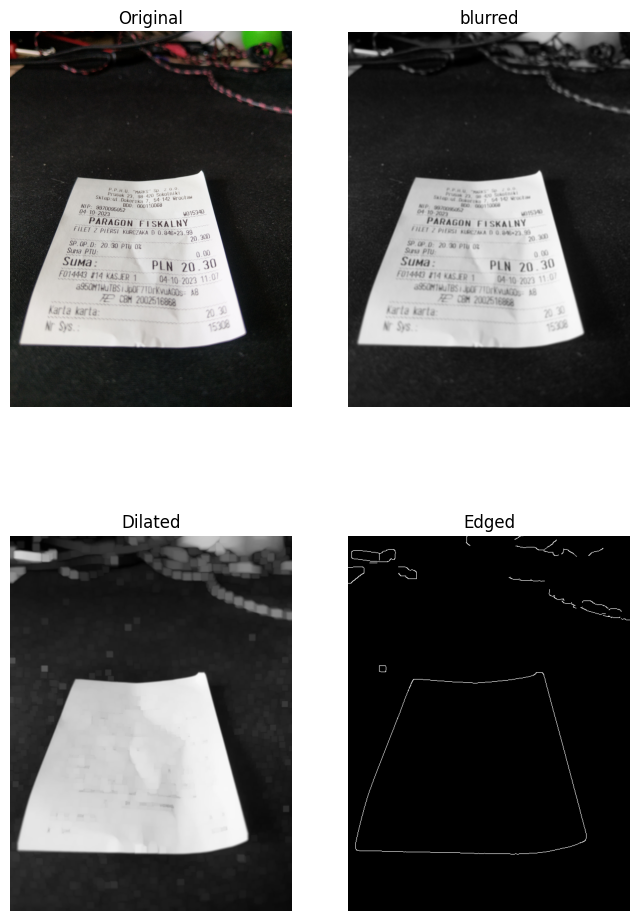

In [208]:
# create figure 
fig = plt.figure(figsize=(8, 12))
# setting values to rows and column variables 
rows = 2
columns = 2
# Adds a subplot at the 1st position 
fig.add_subplot(rows, columns, 1) 

# showing image 
plt.imshow(cv2.cvtColor(image_origin, cv2.COLOR_BGR2RGB))
plt.axis('off') 
plt.title("Original") 
  
# Adds a subplot at the 2nd position 
fig.add_subplot(rows, columns, 2) 
  
# showing image 
plt.imshow(cv2.cvtColor(blurred, cv2.COLOR_GRAY2BGR))
plt.axis('off') 
plt.title("blurred") 
  
# Adds a subplot at the 3rd position 
fig.add_subplot(rows, columns, 3) 
  

# showing image 
plt.imshow(cv2.cvtColor(dilated, cv2.COLOR_GRAY2BGR))
plt.axis('off') 
plt.title("Dilated") 
  
# Adds a subplot at the 4th position 
fig.add_subplot(rows, columns, 4) 
  
# showing image 
plt.imshow(cv2.cvtColor(edged, cv2.COLOR_GRAY2BGR))
plt.axis('off') 
plt.title("Edged") 


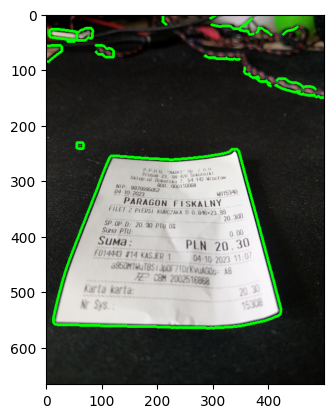

In [209]:
# Detect all contours in Canny-edged image
contours, hierarchy = cv2.findContours(edged, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
image_with_contours = cv2.drawContours(image.copy(), contours, -1, (0,255,0), 3)
plt.imshow(cv2.cvtColor(image_with_contours, cv2.COLOR_BGR2RGB))

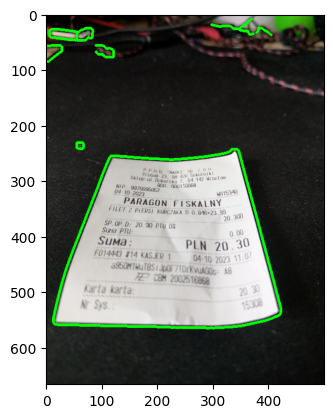

In [210]:
# Get 10 largest contours
largest_contours = sorted(contours, key = cv2.contourArea, reverse = True)[:10]
image_with_largest_contours = cv2.drawContours(image.copy(), largest_contours, -1, (0,255,0), 3)
plt.imshow(cv2.cvtColor(image_with_largest_contours, cv2.COLOR_BGR2RGB))

In [211]:
# find contours in the edge map and sort them by size in descending order
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sorted(cnts, key=cv2.contourArea, reverse=True)

In [212]:
# initialize a contour that corresponds to the receipt outline
receiptCnt = None
# loop over the contours
for c in cnts:
	# approximate the contour
	peri = cv2.arcLength(c, True)
	approx = cv2.approxPolyDP(c, 0.02 * peri, True)
	# if our approximated contour has four points, then we can
	# assume we have found the outline of the receipt
	if len(approx) == 4:
		receiptCnt = approx
		break
# if the receipt contour is empty then our script could not find the
# outline and we should be notified
if receiptCnt is None:
	raise Exception(("Could not find receipt outline. Try debugging your edge detection and contour steps."))

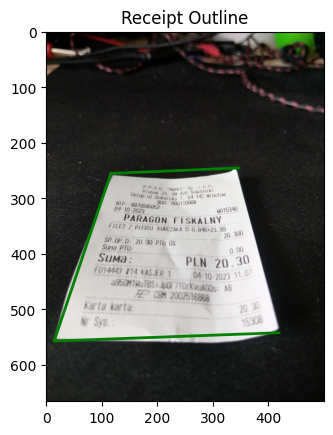

In [213]:
# check to see if we should draw the contour of the receipt on the
# image and then display it to our screen

output = image.copy()
plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
plt.plot(receiptCnt[:, :, 0], receiptCnt[:, :, 1], '-g', lw=2)
plt.title("Receipt Outline")
plt.show()

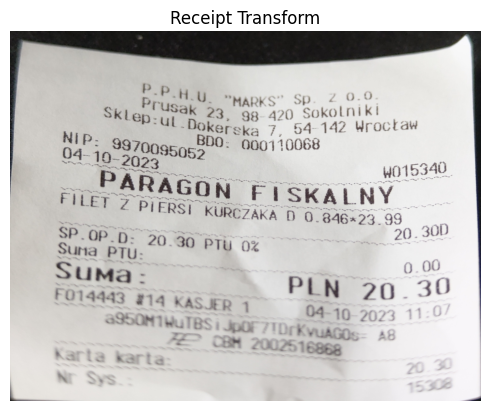

In [214]:

# apply a four-point perspective transform to the *original* image to
# obtain a top-down bird's-eye view of the receipt
receipt = four_point_transform(image_origin, receiptCnt.reshape(4, 2) * ratio)

plt.imshow(cv2.cvtColor(receipt, cv2.COLOR_BGR2RGB))
plt.title("Receipt Transform")
plt.axis("off")
plt.show()